<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/week9/propensity_score_matching_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook does PSM using more covariates including % White, % Hispanic. And the data with <= 200 device_counts are filtered out, using last year's data as baseline, rather than using 2020-01-01 to first case as baseline. This way we factor in seasonal effects.

# 0. load some R packages

In [1]:
cd drive/My\ Drive/week8

/content/drive/My Drive/week8


In [2]:
# if we don't do this there will be annoying warnings
# for using some of the R in jupyter...
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = RRuntimeWarning)

In [3]:
# enable R to python in Colab
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [4]:
import numpy as np
import pandas as pd

# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [5]:
%%R
# install standard propensity matching library in R 
install.packages("MatchIt")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘Matching’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/Matching_4.9-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 298404 bytes (291 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [6]:
%%R
# load MatchIt package
library(MatchIt)

In [7]:
%%R
# install Coarsened Exact Matching package
install.packages('cem')
library(cem)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘combinat’, ‘randomForest’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/combinat_0.0-8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 9197 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

# 1. Propensity score matching with new data without low device count + new covariates

In [8]:
ls

 2016_US_County_Level_Presidential_Results.csv
 2019_data.csv
'2020 County Health Rankings Data - Additional Measure Data.csv'
'2020 County Health Rankings Data - Ranked Measure Data.csv'
 2020_data.csv
 check_if_data_is_alright.ipynb
'Copy of agg_social_dist_2.csv'
 county_data_with_covariates.csv
 county_data_with_reduced_covariates.csv
 data_2019_agg.csv
 data_2020_agg.csv
 data_for_propensity.csv
 days_since.csv
 merged_data.csv
 prepare_new_data.ipynb
 propensity_score_matching_new_data.ipynb
 social_dist_aggregated_on_county.csv
 social_dist_all_trimmed.csv
 social_dist_all_trimmed_new.csv
 social_dist_low_device_count_filtered.csv
 social_dist_reduced.csv
 us_states_governors.csv


In [9]:
dataframe = pd.read_csv("county_data_with_reduced_covariates.csv")

In [10]:
# look at our data
dataframe.head()

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.049691,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.046830,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007099,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.014983,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.043031,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


In [11]:
print(f"this dataset has {dataframe.shape[0]} records.")

this dataset has 2886 records.


In [12]:
dataframe.dropna(inplace=True)

In [13]:
print(f"after dropping this dataset has {dataframe.shape[0]} records.")

after dropping this dataset has 2885 records.


So we only have one record with null values in it, which is good

In [14]:
# look at variables we have in R. (% sign is messed up)
%%R -i dataframe
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.049691482
1     1         AL    Alabama Baldwin County        1003          0.046830245
2     1         AL    Alabama Barbour County        1005          0.007099368
3     1         AL    Alabama    Bibb County        1007          0.014983144
4     1         AL    Alabama  Blount County        1009          0.043030755
5     1         AL    Alabama Bullock County        1011         -0.016498044
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [15]:
# -i means pass in some argument/data from python world to R world
%%R -i dataframe

# using MatchIt package to do PSM - guess it used logistic regression?

m.out <- matchit(SIP.~Median.Household.Income + X..Rural +
                 political_diff+
                 X..Asian + X..Black + 
                 X..Non.Hispanic.White +
                 X..Hispanic,
                 method = "cem", data = dataframe) # cem = coarse exact matching


Using 'treat'='1' as baseline group


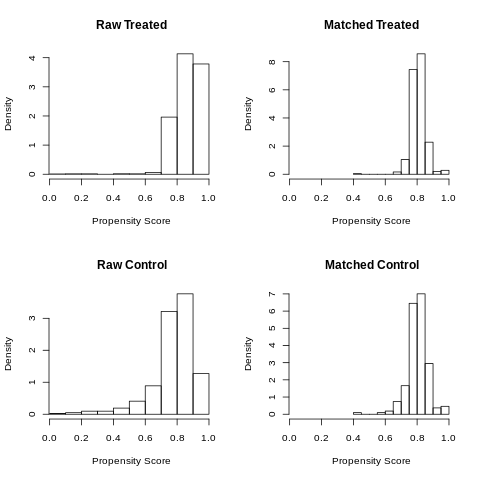

In [16]:
# to see how maching it soind by visualizing distributions
%%R
plot(m.out, type='hist')

[1] "To identify the units, use first mouse button; to stop, use second."
integer(0)


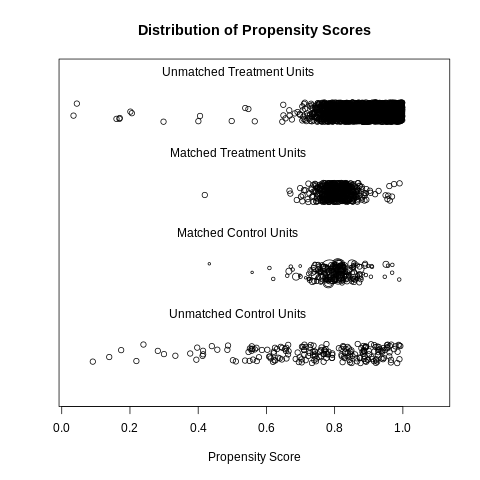

In [17]:
%%R
plot(m.out, type='jitter')

In [18]:
%%R
summary(m.out, standardize=T)


Call:
matchit(formula = SIP. ~ Median.Household.Income + X..Rural + 
    political_diff + X..Asian + X..Black + X..Non.Hispanic.White + 
    X..Hispanic, data = dataframe, method = "cem")

Summary of balance for all data:
                        Means Treated Means Control SD Control Std. Mean Diff.
distance                       0.8686        0.7775     0.1366          1.0354
Median.Household.Income    53133.1868    52880.5779 10329.0766          0.0173
X..Rural                      54.5249       63.0492    28.6537         -0.2773
political_diff                -0.2824       -0.4193     0.2195          0.4401
X..Asian                       1.6940        1.0197     1.3070          0.2262
X..Black                      10.5128        4.2038     9.4272          0.4167
X..Non.Hispanic.White         74.7371       82.1755    14.3581         -0.3651
X..Hispanic                   10.2104        6.5657     6.3019          0.2494
                        eCDF Med eCDF Mean eCDF Max
distance      

we can see from the histogram and jitter plot and summary statistics that this matching is pretty good! - Std. Mean Diff are all $\le$ 0.05, which is good

In [19]:
%%R
# extract matched data.
matched_data <- match.data(m.out)

In [20]:
# import dataframe from R to python.... since I am not familar with manipulating
# R objects 
matched_data = %R matched_data

In [22]:
no_SIP_diff = ((matched_data[matched_data['SIP.'] == 0]['weights'] / \
 matched_data[matched_data['SIP.'] == 0]['weights'].sum()) \
* matched_data[matched_data['SIP.'] == 0]['diff_in_perc_at_home']).sum()

In [23]:
SIP_diff = matched_data[matched_data['SIP.'] == 1]['diff_in_perc_at_home'].mean()

In [24]:
# change in behavior that is brought by SIP policy
SIP_diff - no_SIP_diff

0.004786062832051649

In [25]:
SIP_diff

0.013472934951352957

In [26]:
# change in behavior that is brought by people's own volition
no_SIP_diff

0.008686872119301308

# Conclusion

there is not much difference as we can see... factoring seasonal effects. there is 0.5% difference, much less than our 1.5% difference before.

In [32]:
policy_importance = (SIP_diff - no_SIP_diff) / ((SIP_diff - no_SIP_diff) + (no_SIP_diff)) 

In [33]:
policy_importance

0.35523535512735704

but now we can see that shelter in place contributes 35% to people's change in stay at home behavior, which is a very good number that indicates that policy works